In [4]:
import os
import sys

import astropy.table as at
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
rnd = np.random.RandomState(seed=8675309)

In [5]:
true_alpha = 3.21 
true_beta = 2.44

In [6]:
N = 3

t = at.Table()
t['x'] = np.round(np.sort(rnd.uniform(-5, 5, size=N)), 
                  decimals=1)
t['sigma_y'] = np.round(np.sort(rnd.uniform(0.5, 4, size=N)), 
                        decimals=1)
t['y'] = np.round(rnd.normal(true_alpha * t['x'] + true_beta,
                             t['sigma_y']),
                  decimals=1)

t.write('data1.csv', overwrite=True)
t.write(sys.stdout, format='ascii.latex')

\begin{table}
\begin{tabular}{ccc}
x & sigma_y & y \\
-1.4 & 0.8 & -2.4 \\
2.5 & 1.2 & 8.8 \\
3.1 & 1.9 & 13.8 \\
\end{tabular}
\end{table}


<ErrorbarContainer object of 3 artists>

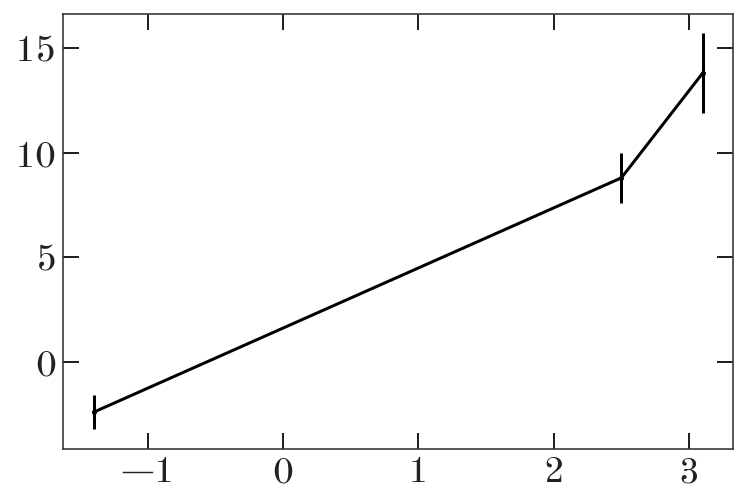

In [7]:
plt.errorbar(t['x'], t['y'], t['sigma_y'])